# Regressor

Create a workflow to train a model to predict the position of a given fragment whitin a standardised space.

Using the same dataset, we will make a comparison between the performance of the same model trained with different methods:
- Images plus tabular data
- Images only

In [12]:
%watermark -a "Lorenzo Cardarelli" -iv -v -m

Author: Lorenzo Cardarelli

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit

PIL        : 9.5.0
watermark  : 2.4.3
cv2        : 4.8.0
seaborn    : 0.12.2
torch      : 2.0.1+cu118
numpy      : 1.24.3
torchvision: 0.15.2+cu118
scipy      : 1.11.3
matplotlib : 3.7.1
skimage    : 0.21.0
pandas     : 2.0.2



## Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from skimage.transform import rescale, resize, downscale_local_mean

# pytorch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim


# training and utils imports
from sklearn.model_selection import train_test_split
from torchinfo import summary
#import cv2
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from tqdm import tqdm

from utils import *
from models import *
from dataset import *

Move computation to GPU if available.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define reproducibility settings:

In [4]:
define_reproducibility(42)

Reproducibility is set to 42.


### Prepare data

Import the pot dataset

In [5]:
pots = load_pots('new_dataset.npz').reshape(-1, 256, 256)

Import the tabular dataset

In [6]:
tabular_data = pd.read_excel('selected_info_new_dataset.xlsx')

View the tabular dataset

In [7]:
tabular_data.head()

,index,ids,context,context_typology,wide_chronology,funeral_function,ID_context,Functional_interpretation,Morphology,Functional_class,manufacturing_technique,material,Grave,Pag.,Fig./Tav.,n.,ID_biblio
0,3747,CSLN_0001,Casinalbo,Funerary,RBA,Urn,7,Tazza/Ciotola,Open shape,Class 2,Handmade,Impasto,12,118.0,85,5,6
1,3748,CSLN_0002,Casinalbo,Funerary,RBA,Urn,7,Vaso a collo/Biconico,Closed shape,Class 3,Handmade,Impasto,10,118.0,85,6,6
2,3749,CSLN_0003,Casinalbo,Funerary,RBA,Urn,7,Olla,Closed shape,Class 3,Handmade,Impasto,14,118.0,85,9,6
3,3750,CSLN_0004,Casinalbo,Funerary,RBA,Urn,7,Vaso a collo/Biconico,Closed shape,Class 3,Handmade,Impasto,15,119.0,86,1,6
4,3751,CSLN_0005,Casinalbo,Funerary,RBA,Urn,7,Tazza/Ciotola,Open shape,Class 2,Handmade,Impasto,16,119.0,86,2,6


Define some tabular and archaeological data to train the regressor model.

In [7]:
encoders = fit_and_transform_encoders(tabular_data, ["Functional_class", "Morphology"])
transformed_data = transform_data_using_encoders(tabular_data[["Functional_class","Morphology"]], encoders) 

Define some hyperparameters and data augmentation methods.

In [8]:
BATCH_SIZE = 128
EPOCHS = 50 #75
LEARNING_RATE = 0.001
IMG_SIZE = 128

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, (0.01,0.01))
    ])

Train and test split.

In [10]:
test_size = 0.2

num_samples = len(tabular_data)
num_samples_test = int(test_size * num_samples)


indices = list(range(num_samples))
indices_train, indices_test = train_test_split(indices, test_size=test_size, random_state=42)


pots_train = pots[tabular_data.index][indices_train]
functional_encoded_train = transformed_data.values[indices_train]

pots_test = pots[tabular_data.index][indices_test]
functional_encoded_test = transformed_data.values[indices_test]

### First attempt: using images and tabular data

Define the dataset and dataloader.

In this training step, we will use a series of archaeological information to train the model and also only the images.

The fragment is simulated creating a mask with variable size and position: the size ranges from 50 to 110 pixels and the position is randomly selected from the pixel of the profile. Both ranges are definided by a uniform distribution.

In [11]:
pots_pytorch_trn = PotTorch(pots_train, functional_encoded_train, 
                            transform=transform, img_size=IMG_SIZE)
pots_pytorch_tst = PotTorch(pots_test, functional_encoded_test, 
                            transform=transform, img_size=IMG_SIZE)

In [12]:
data_loader_train = DataLoader(dataset = pots_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset = pots_pytorch_tst, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Let's visualise the data.

In [13]:
pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, mask, x_filled = next(iter(data_loader_train))

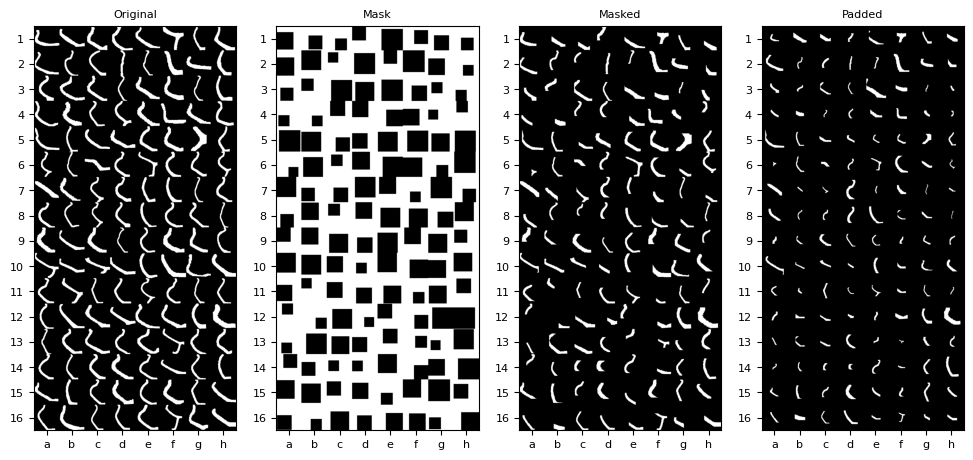

In [14]:
plot_batches([pot, mask, masked_img, padded_tensor], title_list=["Original", "Mask", "Masked", "Padded"], 
             figsize=(12, 8), nrow=8, title_size=8, tick_size=8, save_fig=False)

Instantiate the model.

In [15]:
pretrained_model = CustomModel(num_classes=transformed_data.shape[1])

View the model architecture using `torchinfo.summary()`

In [16]:
summary(pretrained_model, input_size=(128, transformed_data.shape[1] + 1, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
CustomModel                                   [128, 3]                  --
├─ResNet: 1-1                                 [128, 3]                  --
│    └─Conv2d: 2-1                            [128, 64, 64, 64]         28,224
│    └─BatchNorm2d: 2-2                       [128, 64, 64, 64]         128
│    └─ReLU: 2-3                              [128, 64, 64, 64]         --
│    └─MaxPool2d: 2-4                         [128, 64, 32, 32]         --
│    └─Sequential: 2-5                        [128, 256, 32, 32]        --
│    │    └─Bottleneck: 3-1                   [128, 256, 32, 32]        75,008
│    │    └─Bottleneck: 3-2                   [128, 256, 32, 32]        70,400
│    │    └─Bottleneck: 3-3                   [128, 256, 32, 32]        70,400
│    └─Sequential: 2-6                        [128, 512, 16, 16]        --
│    │    └─Bottleneck: 3-4                   [128, 512, 16, 16]        379,39

Train all the layers of the model.

In [17]:
for param in pretrained_model.parameters():
    param.requires_grad = True

Set the criterion and optimizer.

In [18]:
cnn_criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

Train and test the model using a specific training loop

In [19]:
### Prepare some lists to store the training / testing statistics
train_losses = []
test_losses = []
test_metrics = []


for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    ### Set the model to train mode
    pretrained_model.train()
    
    ### Set the training loss to 0
    total_loss_training = 0

    for batch, (pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, _, _) in enumerate(data_loader_train):
        
        ### Move the data to the device (GPU if available) and modify the bounding box coordinates and scale factor according to the constants.
        padded_tensor = padded_tensor.to(device).float()
        bounding_box = bounding_box.to(device).float()
        if len(archeo_info) != 0:
            archeo_info = archeo_info.to(device).float()

        # Normalise the scale factor and the bounding box coordinates
        scale_factor = scale_factor.to(device).float()/2.5
        bounding_box[:, 0] = bounding_box[:, 0] /128
        bounding_box[:, 1] = bounding_box[:, 1] /128

        total_dimensions = torch.cat((bounding_box, scale_factor.unsqueeze(1)), dim=1)
        
        if len(archeo_info) != 0:
        ### Concatenate the padded tensor with the archeological information
            archeo_info = archeo_info.view(BATCH_SIZE, archeo_info.shape[1], 1, 1)
            concat_images = torch.cat((padded_tensor, archeo_info.expand(-1, -1, 128, 128)), dim=1)
            ### Forward pass with the concatenated images
            predicted_dimensions = pretrained_model(concat_images)
        else:
            ### Forward pass with the padded tensor
            predicted_dimensions = pretrained_model(padded_tensor)


        ### Compute the loss
        loss = cnn_criterion(predicted_dimensions, total_dimensions) 



        ### Backward pass
        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()
        
        ### Update the training loss
        total_loss_training += loss.item()

    ### Define the average training loss and append it to the list
    average_loss = total_loss_training / len(data_loader_train)
    train_losses.append(average_loss)

    ### Set the model to evaluation mode
    pretrained_model.eval()
    ### Set the test loss to 0
    total_test_loss = 0

    ### Create two lists to store the predictions and the real values
    predictions = []
    real_total_dimensions = []

    with torch.no_grad():
        for batch, (pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, _, _) in enumerate(data_loader_test):
            
            ### Move the data to the device (GPU if available) and modify the bounding box coordinates and scale factor according to the constants.
            padded_tensor = padded_tensor.to(device).float()
            bounding_box = bounding_box.to(device).float()
            if len(archeo_info) != 0:
                archeo_info = archeo_info.to(device).float()

            # Normalise the scale factor and the bounding box coordinates
            scale_factor = scale_factor.to(device).float()/2.5
            bounding_box[:, 0] = bounding_box[:, 0] /128
            bounding_box[:, 1] = bounding_box[:, 1] /128

            total_dimensions = torch.cat((bounding_box, scale_factor.unsqueeze(1)), dim=1)

            
            if len(archeo_info) != 0:
            ### Concatenate the padded tensor with the archeological information
                archeo_info = archeo_info.view(BATCH_SIZE, archeo_info.shape[1], 1, 1)
                concat_images = torch.cat((padded_tensor, archeo_info.expand(-1, -1, 128, 128)), dim=1)
                ### Forward pass with the concatenated images
                predicted_dimensions = pretrained_model(concat_images)
            else:
                ### Forward pass with the padded tensor
                predicted_dimensions = pretrained_model(padded_tensor)

            ### Compute the loss
            loss = cnn_criterion(predicted_dimensions, total_dimensions)


            ### Save test information and update the test loss
            predictions.extend(predicted_dimensions.cpu().numpy())
            real_total_dimensions.extend(total_dimensions.cpu().numpy())

            total_test_loss += loss.item()

    ### Define the average test loss and append it to the list
    average_loss_test = total_test_loss / len(data_loader_test)
    test_losses.append(average_loss_test)

    ### Print the epoch, the training loss and the test loss
    if epoch % 5 == 0:   
        tqdm.write(f'Epoch [{epoch + 1}/{EPOCHS}] - Training Loss: {average_loss:.4f} - Testing Loss: {average_loss_test:.4f}')



Training Progress:   2%|▏         | 1/50 [00:25<20:40, 25.33s/it]

Epoch [1/50] - Training Loss: 0.0495 - Testing Loss: 0.0514


Training Progress:  12%|█▏        | 6/50 [03:08<21:49, 29.76s/it]

Epoch [6/50] - Training Loss: 0.0065 - Testing Loss: 0.0053


Training Progress:  22%|██▏       | 11/50 [05:15<17:02, 26.22s/it]

Epoch [11/50] - Training Loss: 0.0050 - Testing Loss: 0.0049


Training Progress:  32%|███▏      | 16/50 [07:21<14:28, 25.55s/it]

Epoch [16/50] - Training Loss: 0.0046 - Testing Loss: 0.0044


Training Progress:  42%|████▏     | 21/50 [09:26<12:02, 24.91s/it]

Epoch [21/50] - Training Loss: 0.0048 - Testing Loss: 0.0050


Training Progress:  52%|█████▏    | 26/50 [11:30<09:54, 24.78s/it]

Epoch [26/50] - Training Loss: 0.0042 - Testing Loss: 0.0041


Training Progress:  62%|██████▏   | 31/50 [13:54<09:47, 30.92s/it]

Epoch [31/50] - Training Loss: 0.0041 - Testing Loss: 0.0038


Training Progress:  72%|███████▏  | 36/50 [17:19<09:10, 39.31s/it]

Epoch [36/50] - Training Loss: 0.0040 - Testing Loss: 0.0043


Training Progress:  82%|████████▏ | 41/50 [20:29<05:15, 35.11s/it]

Epoch [41/50] - Training Loss: 0.0037 - Testing Loss: 0.0044


Training Progress:  92%|█████████▏| 46/50 [23:25<02:29, 37.38s/it]

Epoch [46/50] - Training Loss: 0.0039 - Testing Loss: 0.0041


Training Progress: 100%|██████████| 50/50 [26:25<00:00, 31.71s/it]


Same the result in a NumPy array and view the plot of the training and test loss.

In [20]:
predictions_array_archeodata = np.array(predictions)
real_bb_array_archeodata = np.array(real_total_dimensions)

In [21]:
train_losses_array_archeodata = np.array(train_losses)
test_losses_array_archeodata = np.array(test_losses)

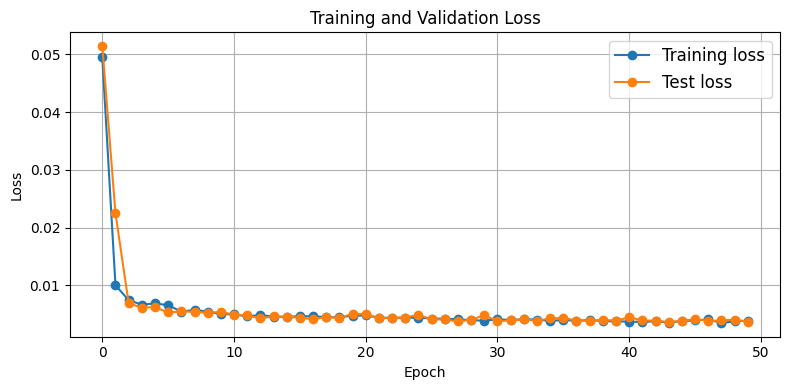

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(train_losses_array_archeodata, label='Training loss', marker='o', linestyle='-')
plt.plot(test_losses_array_archeodata, label='Test loss', marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend(frameon=True, loc='upper right', fontsize='large')

# Display a grid for readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Visualise the model performance using $R^2$.

$R^2$ is a statistical measure used to assess the goodness of fit of a regression model:
- $R^2$ = 0 means that the model does not explain any of the variance in the dependent variable.
- $R^2$ = 1 means that the model perfectly explains all of the variance.

A higher $R^2$ value indicates a better fit between your model and the observed data, suggesting that the independent variables in your model are better at explaining the variation in the dependent variable.

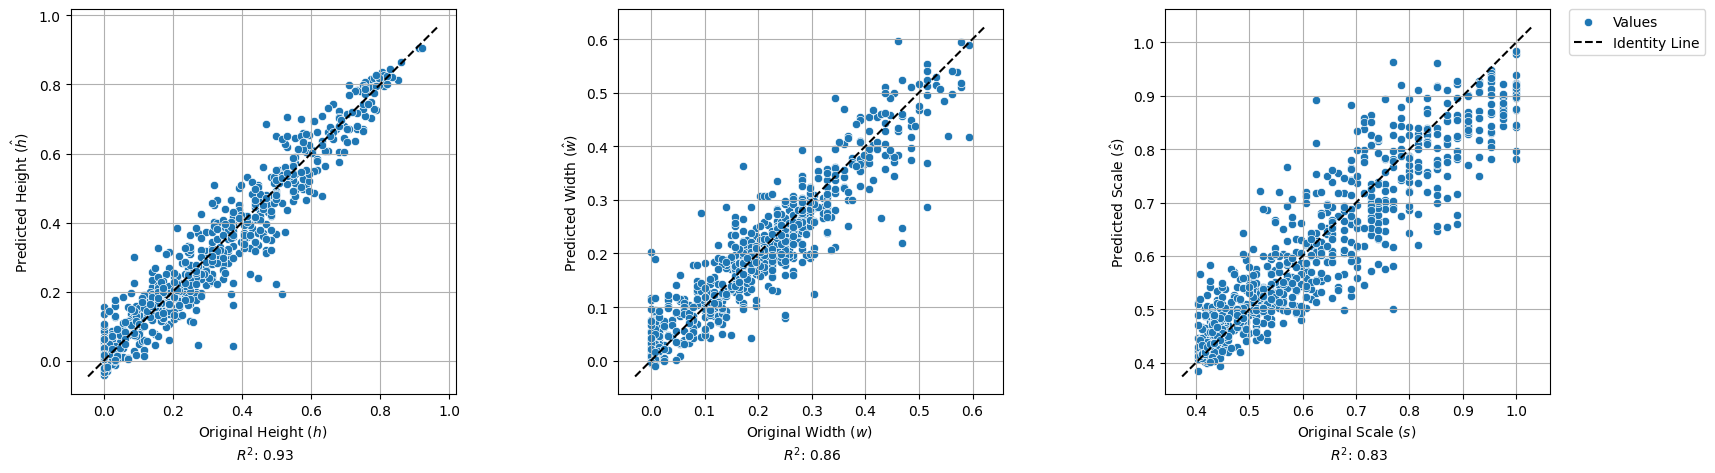

In [23]:
# Set the figure size and create subplots with equal aspect ratio
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)
for axis in ax:
    axis.grid(True)
    axis.set_aspect('equal', adjustable='box')


sns.scatterplot(x=real_bb_array_archeodata[:, 0], y=predictions_array_archeodata[:, 0], ax=ax[0])
sns.scatterplot(x=real_bb_array_archeodata[:, 1], y=predictions_array_archeodata[:, 1], ax=ax[1])
sns.scatterplot(x=real_bb_array_archeodata[:, 2], y=predictions_array_archeodata[:, 2], ax=ax[2], label='Values')

### add identity line
x_0 = np.linspace(*ax[0].get_xlim())
x_1 = np.linspace(*ax[1].get_xlim())
x_2 = np.linspace(*ax[2].get_xlim())

ax[0].plot(x_0, x_0, color='black', linestyle='--')
ax[1].plot(x_1, x_1, color='black', linestyle='--')
ax[2].plot(x_2, x_2, color='black', linestyle='--',  label='Identity Line')

r_score_height = r2_score(real_bb_array_archeodata[:, 0], predictions_array_archeodata[:, 0])
r_score_width = r2_score(real_bb_array_archeodata[:, 1], predictions_array_archeodata[:, 1])

r_score_scale = r2_score(real_bb_array_archeodata[:, 2], predictions_array_archeodata[:, 2])



ax[0].set_xlabel(f"Original Height ($h$) \n $R^2$: {r_score_height:.2f}")
ax[0].set_ylabel("Predicted Height ($\hat{h}$)")
ax[1].set_xlabel(f"Original Width ($w$) \n $R^2$: {r_score_width:.2f}")
ax[1].set_ylabel("Predicted Width ($\hat{w}$)")
ax[2].set_xlabel(f"Original Scale ($s$) \n $R^2$: {r_score_scale:.2f}")
ax[2].set_ylabel("Predicted Scale ($\hat{s}$)")

### add legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

plt.savefig('results_regression.png', dpi=300, bbox_inches='tight')

View some predictions.

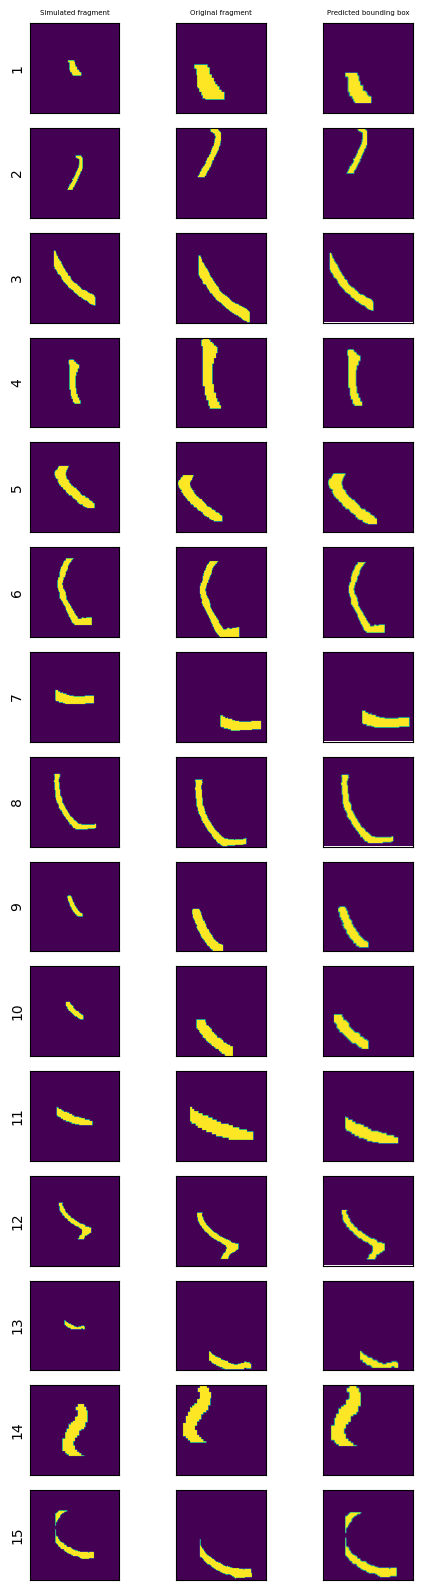

In [24]:
fig, ax = plt.subplots(15, 3, figsize=(5,16))

for n in range(0, 15):
    im_padded_numpy = padded_tensor[n].cpu().numpy().squeeze()
    masked_numpy = masked_img[n].cpu().numpy().squeeze()

    ####
    archeo_info = archeo_info.view(BATCH_SIZE, archeo_info.shape[1], 1, 1)
    concat_images = torch.cat((padded_tensor, archeo_info.expand(-1, -1, 128, 128)), dim=1)
    ####

    predicted_dimensions= pretrained_model(concat_images[n].unsqueeze(0))

    predicted_dimensions_array = predicted_dimensions.cpu().detach().numpy().squeeze()

    new_bb = create_bounding_box(im_padded_numpy, predicted_dimensions_array[1]*128, predicted_dimensions_array[0]*128, predicted_dimensions_array[2]*2.5)

    ax[n, 0].imshow(im_padded_numpy)
    ax[n, 1].imshow(masked_numpy)
    ax[n, 2].imshow(new_bb)

    
    # remove all the axes (ticks and labels) from the plot
    ax[n, 0].set_xticks([])
    ax[n, 0].set_yticks([])
    ax[n, 1].set_xticks([])
    ax[n, 1].set_yticks([])
    ax[n, 2].set_xticks([])
    ax[n, 2].set_yticks([])
    
    ax[0, 0].set_title(f"Simulated fragment", fontsize=5)
    ax[0, 1].set_title(f"Original fragment", fontsize=5)
    ax[0, 2].set_title(f"Predicted bounding box", fontsize=5)

    ax[n, 2].set_xlim(0, 128)
    ax[n, 2].set_ylim(128, 0)

    ax[n, 0].set_ylabel(n+1)




fig.tight_layout()
## save plot


#### Save model

In [25]:
torch.save(pretrained_model.state_dict(), "regressor_model.pth")

### Second attempt: using only images

In [26]:
pots_pytorch_trn_no_tabular = PotTorch(pots_train, None, transform=transform, img_size=IMG_SIZE)
pots_pytorch_tst_no_tabular = PotTorch(pots_test, None, transform=transform, img_size=IMG_SIZE)

In [27]:
data_loader_train_no_tabular = DataLoader(dataset = pots_pytorch_trn_no_tabular, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_test_no_tabular = DataLoader(dataset = pots_pytorch_tst_no_tabular, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [28]:
pretrained_model_no_tabular = CustomModel(num_classes=0).to(device)

In [29]:
for param in pretrained_model_no_tabular.parameters():
    param.requires_grad = True

In [30]:
cnn_criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(pretrained_model_no_tabular.parameters(), lr=0.001)

In [31]:
### Prepare some lists to store the training / testing statistics
train_losses = []
test_losses = []
test_metrics = []

for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    ### Set the model to train mode
    pretrained_model_no_tabular.train()
    
    ### Set the training loss to 0
    total_loss_training = 0

    for batch, (pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, _, _) in enumerate(data_loader_train_no_tabular):
        
        ### Move the data to the device (GPU if available) and modify the bounding box coordinates and scale factor according to the constants.
        padded_tensor = padded_tensor.to(device).float()
        bounding_box = bounding_box.to(device).float()
        if len(archeo_info) != 0:
            archeo_info = archeo_info.to(device).float()

        # Normalise the scale factor and the bounding box coordinates
        scale_factor = scale_factor.to(device).float()/2.5
        bounding_box[:, 0] = bounding_box[:, 0]/128
        bounding_box[:, 1] = bounding_box[:, 1]/128

        total_dimensions = torch.cat((bounding_box, scale_factor.unsqueeze(1)), dim=1)
        
        if len(archeo_info) != 0:
        ### Concatenate the padded tensor with the archeological information
            archeo_info = archeo_info.view(BATCH_SIZE, archeo_info.shape[1], 1, 1)
            concat_images = torch.cat((padded_tensor, archeo_info.expand(-1, -1, 128, 128)), dim=1)
            ### Forward pass with the concatenated images
            predicted_dimensions = pretrained_model_no_tabular(concat_images)
        else:
            ### Forward pass with the padded tensor
            predicted_dimensions = pretrained_model_no_tabular(padded_tensor)


        ### Compute the loss
        loss = cnn_criterion(predicted_dimensions, total_dimensions) 

        ### Backward pass
        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()
        
        ### Update the training loss
        total_loss_training += loss.item()

    ### Define the average training loss and append it to the list
    average_loss = total_loss_training / len(data_loader_train_no_tabular)
    train_losses.append(average_loss)

    ### Set the model to evaluation mode
    pretrained_model_no_tabular.eval()
    ### Set the test loss to 0
    total_test_loss = 0

    ### Create two lists to store the predictions and the real values
    predictions = []
    real_total_dimensions = []

    with torch.no_grad():
        for batch, (pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, _, _) in enumerate(data_loader_test_no_tabular):
            
            ### Move the data to the device (GPU if available) and modify the bounding box coordinates and scale factor according to the constants.
            padded_tensor = padded_tensor.to(device).float()
            bounding_box = bounding_box.to(device).float()
            if len(archeo_info) != 0:
                archeo_info = archeo_info.to(device).float()

            # Normalise the scale factor and the bounding box coordinates
            scale_factor = scale_factor.to(device).float()/2.5
            bounding_box[:, 0] = bounding_box[:, 0]/128
            bounding_box[:, 1] = bounding_box[:, 1]/128

            total_dimensions = torch.cat((bounding_box, scale_factor.unsqueeze(1)), dim=1)
            
            if len(archeo_info) != 0:
            ### Concatenate the padded tensor with the archeological information
                archeo_info = archeo_info.view(BATCH_SIZE, archeo_info.shape[1], 1, 1)
                concat_images = torch.cat((padded_tensor, archeo_info.expand(-1, -1, 128, 128)), dim=1)
                ### Forward pass with the concatenated images
                predicted_dimensions = pretrained_model_no_tabular(concat_images)
            else:
                ### Forward pass with the padded tensor
                predicted_dimensions = pretrained_model_no_tabular(padded_tensor)

            ### Compute the loss
            loss = cnn_criterion(predicted_dimensions, total_dimensions)

            ### Save test information and update the test loss
            predictions.extend(predicted_dimensions.cpu().numpy())
            real_total_dimensions.extend(total_dimensions.cpu().numpy())
            total_test_loss += loss.item()

    ### Define the average test loss and append it to the list
    average_loss_test = total_test_loss / len(data_loader_test_no_tabular)
    test_losses.append(average_loss_test)

    ### Print the epoch, the training loss and the test loss
    if epoch % 5 == 0:   
        tqdm.write(f'Epoch [{epoch + 1}/{EPOCHS}] - Training Loss: {average_loss:.4f} - Testing Loss: {average_loss_test:.4f}')



Training Progress:   2%|▏         | 1/50 [00:34<28:17, 34.65s/it]

Epoch [1/50] - Training Loss: 0.0417 - Testing Loss: 0.0304


Training Progress:  12%|█▏        | 6/50 [03:44<28:38, 39.05s/it]

Epoch [6/50] - Training Loss: 0.0075 - Testing Loss: 0.0073


Training Progress:  22%|██▏       | 11/50 [07:47<30:03, 46.23s/it]

Epoch [11/50] - Training Loss: 0.0067 - Testing Loss: 0.0064


Training Progress:  32%|███▏      | 16/50 [10:43<20:59, 37.05s/it]

Epoch [16/50] - Training Loss: 0.0062 - Testing Loss: 0.0065


Training Progress:  42%|████▏     | 21/50 [13:36<16:53, 34.95s/it]

Epoch [21/50] - Training Loss: 0.0057 - Testing Loss: 0.0063


Training Progress:  52%|█████▏    | 26/50 [16:29<13:53, 34.73s/it]

Epoch [26/50] - Training Loss: 0.0055 - Testing Loss: 0.0055


Training Progress:  62%|██████▏   | 31/50 [19:23<10:59, 34.71s/it]

Epoch [31/50] - Training Loss: 0.0053 - Testing Loss: 0.0060


Training Progress:  72%|███████▏  | 36/50 [22:16<08:05, 34.68s/it]

Epoch [36/50] - Training Loss: 0.0053 - Testing Loss: 0.0059


Training Progress:  82%|████████▏ | 41/50 [25:08<05:06, 34.06s/it]

Epoch [41/50] - Training Loss: 0.0051 - Testing Loss: 0.0055


Training Progress:  92%|█████████▏| 46/50 [27:58<02:17, 34.35s/it]

Epoch [46/50] - Training Loss: 0.0049 - Testing Loss: 0.0051


Training Progress: 100%|██████████| 50/50 [30:19<00:00, 36.39s/it]


In [32]:
predictions_array_no_archeodata = np.array(predictions)
real_bb_array_no_archeodata = np.array(real_total_dimensions)

In [33]:
train_losses_array_no_archeodata = np.array(train_losses)
test_losses_array_no_archeodata = np.array(test_losses)

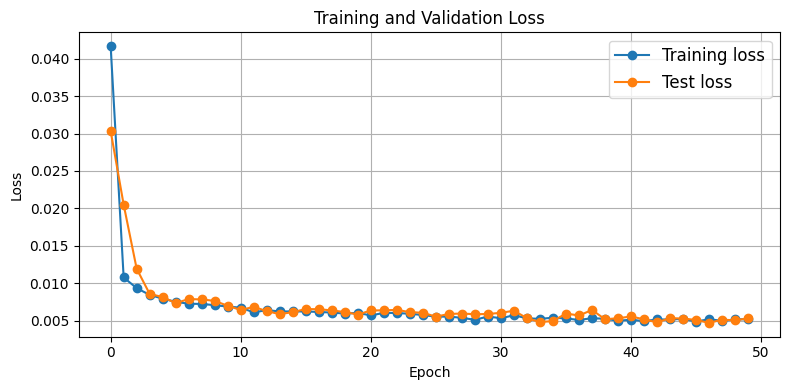

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(train_losses_array_no_archeodata, label='Training loss', marker='o', linestyle='-')
plt.plot(test_losses_array_no_archeodata, label='Test loss', marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend(frameon=True, loc='upper right', fontsize='large')

# Display a grid for readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

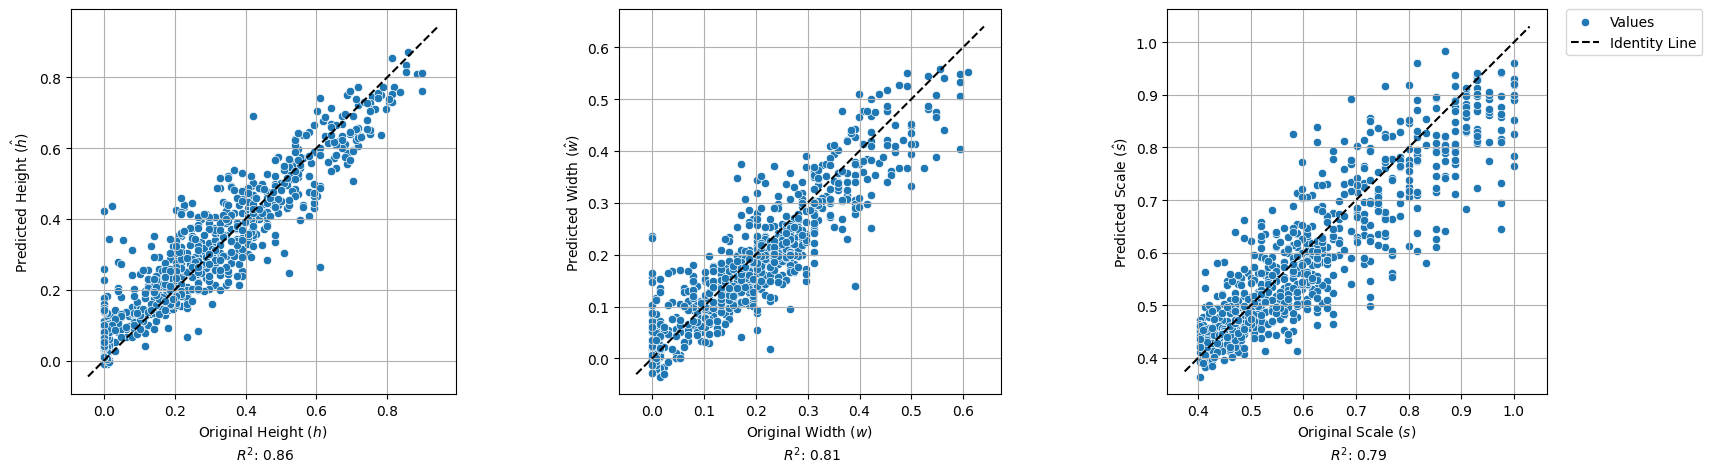

In [35]:
# Set the figure size and create subplots with equal aspect ratio
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)
for axis in ax:
    axis.grid(True)
    axis.set_aspect('equal', adjustable='box')


sns.scatterplot(x=real_bb_array_no_archeodata[:, 0], y=predictions_array_no_archeodata[:, 0], ax=ax[0])
sns.scatterplot(x=real_bb_array_no_archeodata[:, 1], y=predictions_array_no_archeodata[:, 1], ax=ax[1])
sns.scatterplot(x=real_bb_array_no_archeodata[:, 2], y=predictions_array_no_archeodata[:, 2], ax=ax[2], label='Values')

### add identity line
x_0 = np.linspace(*ax[0].get_xlim())
x_1 = np.linspace(*ax[1].get_xlim())
x_2 = np.linspace(*ax[2].get_xlim())
ax[0].plot(x_0, x_0, color='black', linestyle='--')
ax[1].plot(x_1, x_1, color='black', linestyle='--')
ax[2].plot(x_2, x_2, color='black', linestyle='--',  label='Identity Line')

r_score_height = r2_score(real_bb_array_no_archeodata[:, 0], predictions_array_no_archeodata[:, 0])
r_score_width = r2_score(real_bb_array_no_archeodata[:, 1], predictions_array_no_archeodata[:, 1])

r_score_scale = r2_score(real_bb_array_no_archeodata[:, 2], predictions_array_no_archeodata[:, 2])



ax[0].set_xlabel(f"Original Height ($h$) \n $R^2$: {r_score_height:.2f}")
ax[0].set_ylabel("Predicted Height ($\hat{h}$)")
ax[1].set_xlabel(f"Original Width ($w$) \n $R^2$: {r_score_width:.2f}")
ax[1].set_ylabel("Predicted Width ($\hat{w}$)")
ax[2].set_xlabel(f"Original Scale ($s$) \n $R^2$: {r_score_scale:.2f}")
ax[2].set_ylabel("Predicted Scale ($\hat{s}$)")

### add legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

plt.savefig('results_regression_no_archaeological.png', dpi=300, bbox_inches='tight')


### Final remarks

In [36]:
my_res = []

r_score_height_archeodata = r2_score(real_bb_array_archeodata[:, 0], predictions_array_archeodata[:, 0])
r_score_width_archeodata = r2_score(real_bb_array_archeodata[:, 1], predictions_array_archeodata[:, 1])
r_score_archeodata = r2_score(real_bb_array_archeodata[:, 2], predictions_array_archeodata[:, 2])

my_res.append((r_score_height_archeodata, r_score_width_archeodata, r_score_archeodata))

r_score_height_no_archeodata = r2_score(real_bb_array_no_archeodata[:, 0], predictions_array_no_archeodata[:, 0])
r_score_width_no_archeodata = r2_score(real_bb_array_no_archeodata[:, 1], predictions_array_no_archeodata[:, 1])
r_score_no_archeodata = r2_score(real_bb_array_no_archeodata[:, 2], predictions_array_no_archeodata[:, 2])

my_res.append((r_score_height_no_archeodata, r_score_width_no_archeodata, r_score_no_archeodata))

Save  and view the result in a DataFrame.

In [37]:
res_df = pd.DataFrame(my_res, columns=['Height', 'Width', 'Scale'], index=['Using archeological tabular data', 'Only using images'])

In [38]:
res_df.round(2)

,Height,Width,Scale
Using archeological tabular data,0.93,0.86,0.83
Only using images,0.86,0.81,0.79


Compare the performance of the two models using the loss

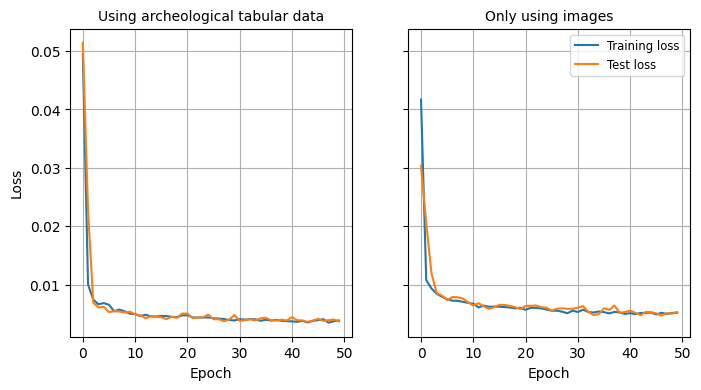

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for axis in ax:
    axis.grid(True)

ax[0].plot(train_losses_array_archeodata, label='Training loss', linestyle='-')
ax[0].plot(test_losses_array_archeodata, label='Test loss', linestyle='-')

ax[1].plot(train_losses_array_no_archeodata, label='Training loss', linestyle='-')
ax[1].plot(test_losses_array_no_archeodata, label='Test loss', linestyle='-')

ax[1].legend(frameon=True, loc='upper right', fontsize='small')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[0].set_title('Using archeological tabular data', fontsize=10)
ax[1].set_title('Only using images', fontsize=10)


plt.savefig('losses_regressor.png', dpi=300, bbox_inches='tight');